<a href="https://colab.research.google.com/github/hadiaramzan2199/SemEval2026-Task-10/blob/main/LLM-Assignment-2/tfidf_logreg_ass2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# STEP 0 — Clone the official starter pack
!git clone https://github.com/hide-ous/semeval26_task10_starter_pack.git
%cd semeval26_task10_starter_pack

# Install base dependencies
!pip install -q pandas matplotlib seaborn numpy datasets sentencepiece transformers

# Install task-specific requirements
!pip install -r requirements.txt


Cloning into 'semeval26_task10_starter_pack'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 102 (delta 55), reused 68 (delta 26), pack-reused 0 (from 0)
Receiving objects: 100% (102/102), 47.03 KiB | 5.22 MiB/s, done.
Resolving deltas: 100% (55/55), done.
/content/semeval26_task10_starter_pack
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 86.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.9/887.9 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 124.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9

In [2]:
from google.colab import files
uploaded = files.upload()   # upload train_redacted.jsonl from Zenodo

Saving train_redacted.jsonl to train_redacted.jsonl


In [3]:
!python rehydrate_data.py --input train_redacted.jsonl --output train_rehydrated.jsonl


/content/semeval26_task10_starter_pack/rehydrate_data.py:29: SyntaxWarning: invalid escape sequence '\W'
  return re.sub("http(.+)?(\W|$)", url_replacement_token, x)
Rehydrating comments:   0% 0/9 [00:00<?, ?it/s]/content/semeval26_task10_starter_pack/rehydrate_data.py:23: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ' '.join(soup.findAll(string=True))
Rehydrating comments:  11% 1/9 [00:01<00:13,  1.75s/it]Warning: Could not rehydrate comment with id 't1_ewekgmh'
Rehydrating comments:  22% 2/9 [00:03<00:10,  1.52s/it]Warning: Could not rehydrate comment with id 't1_euna7wh'
Rehydrating comments:  33% 3/9 [00:04<00:08,  1.41s/it]Warning: Could not rehydrate comment with id 't1_f7yvawr'
Rehydrating comments:  44% 4/9 [00:05<00:06,  1.34s/it]Warning: Could not rehydrate comment with id 't1_fdhnr97'
Rehydrating comments:  56% 5/9 [00:06<00:05,  1.32s/it]Warning: Could not rehydrate comment with id 't1_ewtwg9o'
Reh

In [4]:
import pandas as pd
import json

def load_jsonl(path):
    rows = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            rows.append(json.loads(line))
    return pd.DataFrame(rows)

train = load_jsonl("train_rehydrated.jsonl")
dev   = load_jsonl("dev_redacted.jsonl")   # still redacted, but fine for now

print("Train:", train.shape)
print("Dev:", dev.shape)
train.head()


Train: (4316, 6)
Dev: (100, 3)


,_id,text,subreddit,conspiracy,markers,annotator
0,t1_f7ju17o,A great article on what's taking place in Boli...,conspiracy,Yes,"[{'startIndex': 8, 'endIndex': 15, 'type': 'Ev...",annotator_0
1,t1_k5c5yyz,Chris Lehto interviews Ashton Forbes about his...,HighStrangeness,Can't tell,[],annotator_1
2,t1_givys64,Germany has upset other EU member states by se...,europe,No,"[{'startIndex': 0, 'endIndex': 7, 'type': 'Act...",annotator_2
3,t1_joq538t,"Redditors are, just like most social media use...",Republican,Can't tell,"[{'startIndex': 0, 'endIndex': 9, 'type': 'Act...",annotator_3
4,t1_hlk1vci,u/DLWzll shared a couple days ago how the Virg...,ForwardPartyUSA,Can't tell,[],annotator_29


TF-IDF + Logistic Regression

In [5]:
!pip install langdetect textblob emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 14.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 33.8 MB/s eta 0:00:00
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=71fc66d4fdd916d01f7ec3760ff0ee21c81fb2fe1f93254dbee5350d42a89f44
  Stored in directory: /root/.cache/pip/wheels/c1/67/88/e844b5b022812e15a52e4eaa38a1e709e99f06f6639d7e3ba7
Successfully built langdetect


In [6]:
#Build Feature Extraction Helpers
from langdetect import detect, DetectorFactory
from textblob import TextBlob
import emoji
import numpy as np

DetectorFactory.seed = 0  # make langdetect deterministic

def detect_lang_safe(text):
    try:
        return detect(text)
    except:
        return "unknown"

def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

def count_emoji(text):
    return sum(char in emoji.EMOJI_DATA for char in text)


In [7]:
#Prepare X and y From the Data
X = train["text"].fillna("")
y = train["conspiracy"]
print(y.value_counts())


conspiracy
No            1990
Yes           1541
Can't tell     785
Name: count, dtype: int64


In [8]:
#Train/Validation Split
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape[0])
print("Val size:",   X_val.shape[0])


Train size: 3452
Val size: 864


In [9]:
#Character-Level TF-IDF (3–5 grams)
from sklearn.feature_extraction.text import TfidfVectorizer

char_tfidf = TfidfVectorizer(
    analyzer="char",
    ngram_range=(3,5),
    min_df=3,
    max_features=50000,
    sublinear_tf=True
)


In [10]:
#Fit on training text
X_train_tfidf = char_tfidf.fit_transform(X_train)
X_val_tfidf   = char_tfidf.transform(X_val)

X_train_tfidf.shape, X_val_tfidf.shape


((3452, 50000), (864, 50000))

In [11]:
#Build Meta-Features (Language + Sentiment + Emoji)
import pandas as pd

def build_meta_features(text_series):
    langs = []
    sents = []
    emojis = []

    for t in text_series:
        langs.append(detect_lang_safe(t))
        sents.append(get_sentiment(t))
        emojis.append(count_emoji(t))

    meta = pd.DataFrame({
        "lang": langs,
        "sentiment": sents,
        "emoji_count": emojis
    })

    # One-hot encode language
    meta = pd.get_dummies(meta, columns=["lang"])
    return meta

meta_train = build_meta_features(X_train)
meta_val   = build_meta_features(X_val)

meta_train.head()


,sentiment,emoji_count,lang_en,lang_id
0,0.066667,0,True,False
1,-0.145833,0,True,False
2,0.109596,0,True,False
3,0.104167,0,True,False
4,-0.005128,0,True,False


In [17]:
meta_val = meta_val.reindex(columns=meta_train.columns, fill_value=0)


In [18]:
#Combine TF-IDF and meta features
# Convert to numeric
meta_train = meta_train.astype(float)
meta_val   = meta_val.astype(float)

from scipy.sparse import csr_matrix, hstack

meta_train_sp = csr_matrix(meta_train.values)
meta_val_sp   = csr_matrix(meta_val.values)

# Combine with TF-IDF features
X_train_final = hstack([X_train_tfidf, meta_train_sp])
X_val_final   = hstack([X_val_tfidf,   meta_val_sp])

X_train_final.shape, X_val_final.shape


((3452, 50004), (864, 50004))

In [19]:
#Define and Train Logistic Regression
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(
    max_iter=500,
    class_weight="balanced",
    n_jobs=-1,
    solver="lbfgs"
)

log_reg.fit(X_train_final, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,500
,multi_class,'deprecated'


In [20]:
#Evaluate on Validation Set
from sklearn.metrics import classification_report, confusion_matrix

y_val_pred = log_reg.predict(X_val_final)

print(classification_report(y_val, y_val_pred))


              precision    recall  f1-score   support

  Can't tell       0.35      0.32      0.34       157
          No       0.62      0.62      0.62       398
         Yes       0.56      0.58      0.57       309

    accuracy                           0.55       864
   macro avg       0.51      0.51      0.51       864
weighted avg       0.55      0.55      0.55       864



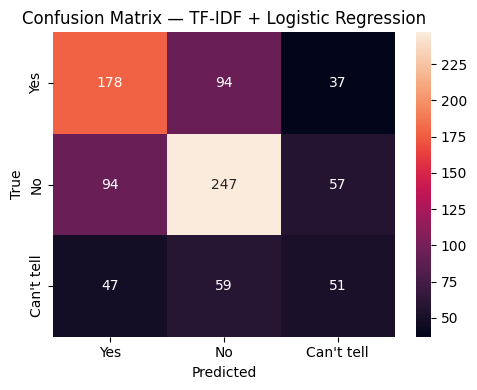

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cm = confusion_matrix(y_val, y_val_pred, labels=["Yes", "No", "Can't tell"])
cm_df = pd.DataFrame(cm, index=["Yes", "No", "Can't tell"], columns=["Yes", "No", "Can't tell"])

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, fmt="d")
plt.title("Confusion Matrix — TF-IDF + Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [22]:
import joblib

joblib.dump({
    "vectorizer": char_tfidf,
    "meta_columns": list(meta_train.columns),
    "classifier": log_reg
}, "baseline_tfidf_logreg_conspiracy.pkl")

print("Saved model as baseline_tfidf_logreg_conspiracy.pkl")


Saved model as baseline_tfidf_logreg_conspiracy.pkl
